# Tutorial

In [1]:
import scedar as sce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from collections import namedtuple
from collections import Counter

In [2]:
# plt.style.use('dark_background')
plt.style.use('default')
%matplotlib inline

## Read data

Zeisel: STRT-Seq. Mouse brain.

In [3]:
RealDataset = namedtuple('RealDataset',
                         ['id', 'x', 'coldata'])

In [4]:
%%time
zeisel = RealDataset(
    'Zeisel', 
    pd.read_csv('data/real_csvs/zeisel_counts.csv', index_col=0),
    pd.read_csv('data/real_csvs/zeisel_coldata.csv', index_col=0))

CPU times: user 7.3 s, sys: 873 ms, total: 8.17 s
Wall time: 8.21 s


## Exploratory Data Analysis

### Check dimensions and data

In [5]:
zeisel.x.shape

(19972, 3005)

In [6]:
zeisel.x.iloc[:3, :3]

,X1,X1.1,X1.2
Tspan12,0,0,0
Tshz1,3,1,0
Fnbp1l,3,1,6


In [7]:
zeisel.coldata.head()

,clust_id,cell_type1,total_features,log10_total_features,total_counts,log10_total_counts,pct_counts_top_50_features,pct_counts_top_100_features,pct_counts_top_200_features,pct_counts_top_500_features,...,log10_total_features_feature_control,total_counts_feature_control,log10_total_counts_feature_control,pct_counts_feature_control,total_features_ERCC,log10_total_features_ERCC,total_counts_ERCC,log10_total_counts_ERCC,pct_counts_ERCC,is_cell_control
X1,1,interneurons,4848,3.685652,21580,4.334072,19.819277,25.949954,34.147359,48.535681,...,0,0,0,0,0,0,0,0,0,False
X1.1,1,interneurons,4685,3.670802,21748,4.337439,19.293728,26.011587,34.715836,50.455214,...,0,0,0,0,0,0,0,0,0,False
X1.2,1,interneurons,6028,3.780245,31642,4.500278,17.423045,23.487769,31.369699,45.970545,...,0,0,0,0,0,0,0,0,0,False
X1.3,1,interneurons,5824,3.765296,32914,4.517394,19.593486,26.122623,34.687367,49.222215,...,0,0,0,0,0,0,0,0,0,False
X1.4,1,interneurons,4701,3.672283,21530,4.333064,15.397120,21.634928,30.380864,46.339991,...,0,0,0,0,0,0,0,0,0,False


In [8]:
labs = zeisel.coldata['cell_type1'].values.tolist()

In [9]:
Counter(labs).most_common()

[('ca1pyramidal', 948),
 ('oligodendrocytes', 820),
 ('s1pyramidal', 390),
 ('interneurons', 290),
 ('astrocytes', 198),
 ('endothelial', 175),
 ('microglia', 98),
 ('mural', 60),
 ('ependymal', 26)]

### Create an instance of scedar data structure

The `sce.eda.SampleDistanceMatrix` class stores the data matrix and distance matrix of a scRNA-seq dataset without cell type label. The distance matrix is computed only when necessary, which could also be directly provided by the user. The `nprocs` parameter specifies the number of CPU cores to use for methods that support parallel computation.

In [10]:
%%time
sdm = sce.eda.SampleDistanceMatrix(
    zeisel.x.values.T,
    fids=zeisel.x.index.values.tolist(),
    metric='cosine', nprocs=16)

CPU times: user 158 ms, sys: 246 ms, total: 404 ms
Wall time: 403 ms


### t-SNE

Label text is added to randomly selected points in each category. Change `random_state` value to select differet set of points.

In [11]:
%%time
tsne_x = sdm.tsne(perplexity=30, n_iter=3000, random_state=111)

CPU times: user 1min 23s, sys: 24.6 s, total: 1min 48s
Wall time: 1min 5s


CPU times: user 94.2 ms, sys: 74.3 ms, total: 169 ms
Wall time: 88.2 ms


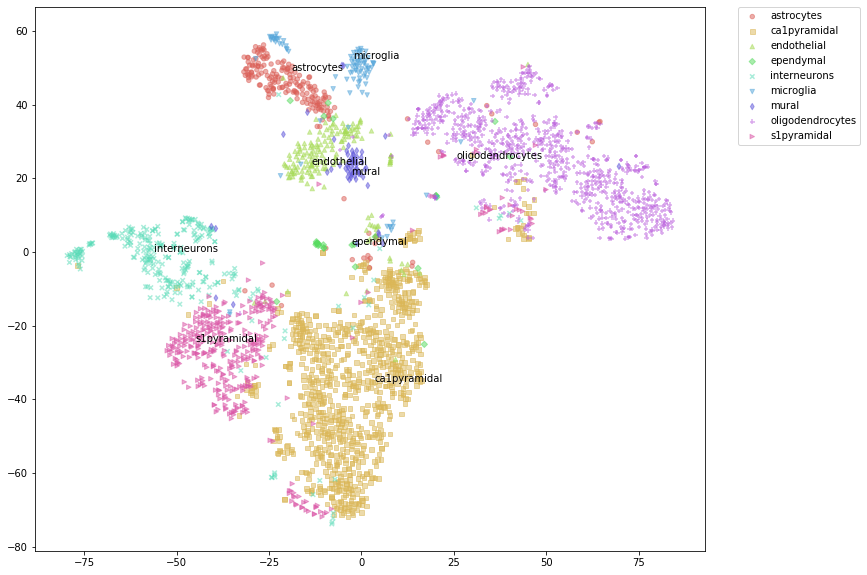

In [12]:
%%time
sdm.tsne_plot(labels=labs, figsize=(15, 10), alpha=0.5, s=20,
              n_txt_per_cluster=1, plot_different_markers=True,
              shuffle_label_colors=False, random_state=17)

### UMAP

Label text is added to randomly selected points in each category. Change `random_state` value to select differet set of points.

/mnt/isilon/cbmi/variome/yuanchao/miniconda3/envs/py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 1min 20s, sys: 2min 19s, total: 3min 40s
Wall time: 17.3 s


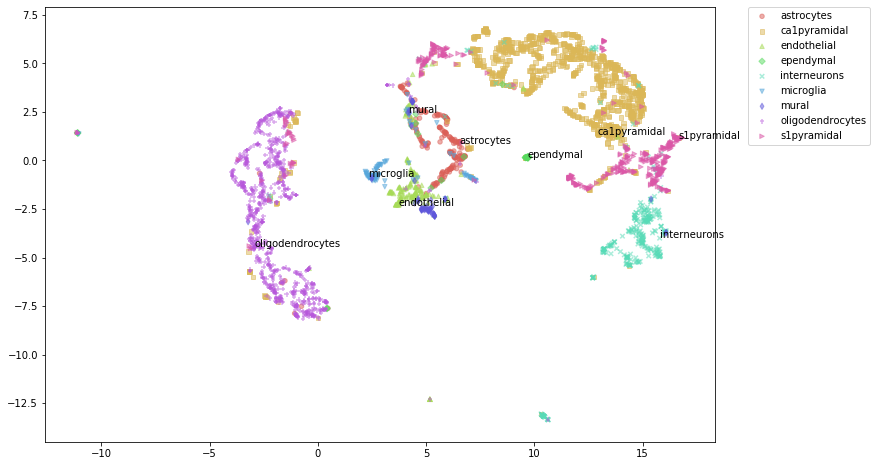

In [13]:
%%time
fig = sdm.umap_plot(labels=labs, alpha=0.5, s=20,
                    plot_different_markers=True,
                    n_txt_per_cluster=1,
                    figsize=(15, 8), random_state=99)
fig

## Clustering

In [14]:
%%time
mirac_res = sce.cluster.MIRAC(
    sdm._last_tsne, metric='euclidean',
    linkage='ward', min_cl_n=25,
    min_split_mdl_red_ratio=0.00,
    optimal_ordering=False,
    cl_mdl_scale_factor=0.80, verbose=False)

CPU times: user 6.83 s, sys: 5.13 s, total: 12 s
Wall time: 5.45 s


### Visualize pairwise distance matrix

In [15]:
# setup for pairwise distance matrix visualization
# this procedure will be simplified in future
# versions of scedar

# convert labels to random integers, in order
# to better visualize the pairwise distance
# matrix
np.random.seed(123)
uniq_labs = sorted(set(mirac_res.labs))
rand_lab_lut = dict(zip(uniq_labs,
                        np.random.choice(len(uniq_labs),
                                         size=len(uniq_labs),
                                         replace=False).tolist()))
olabs = mirac_res._labs
mirac_res._labs = [rand_lab_lut[l] for l in olabs]

# visualize the original cosine pairwise
# distance matrix rather than the t-SNE
# euclidean pairwise distance
tsne_euc_d = mirac_res._sdm._d
mirac_res._sdm._lazy_load_d = sdm._d

# order orignial cell types according to hac
# optimal ordering
mirac_res_ord_cell_types = [labs[i] for i in mirac_res._hac_tree.leaf_ids()]

CPU times: user 487 ms, sys: 163 ms, total: 650 ms
Wall time: 649 ms


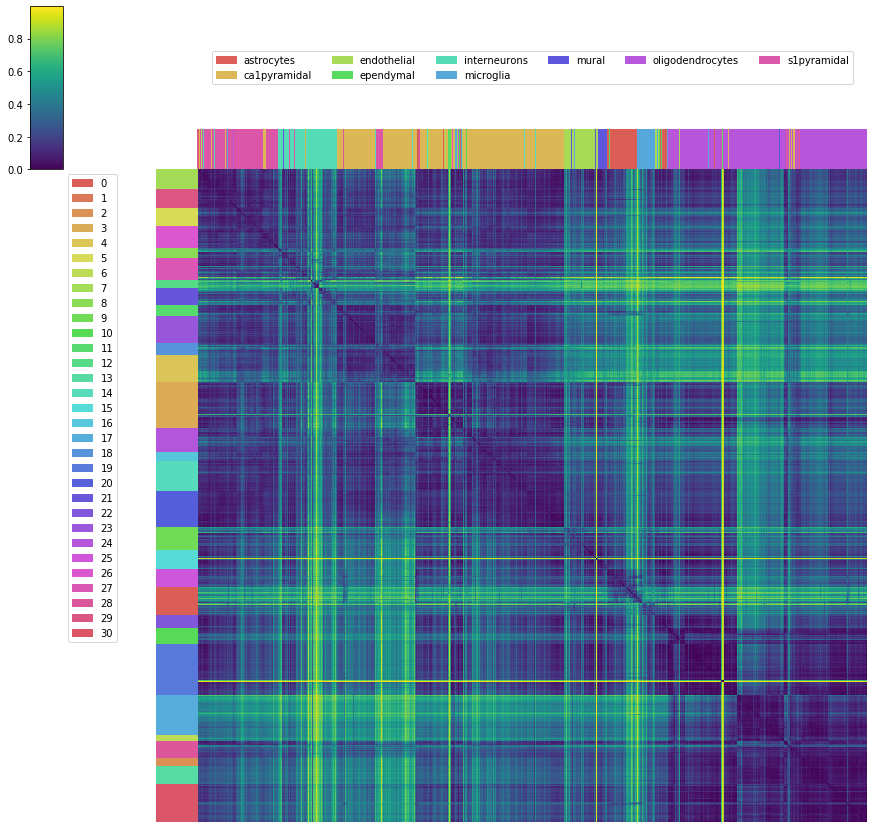

In [16]:
%%time
mirac_res.dmat_heatmap(col_labels=mirac_res_ord_cell_types,
                       figsize=(15, 15), cmap='viridis')

### Visualize t-SNE

In [17]:
slcs = sdm.to_classified(mirac_res.labs)

CPU times: user 211 ms, sys: 127 ms, total: 338 ms
Wall time: 143 ms


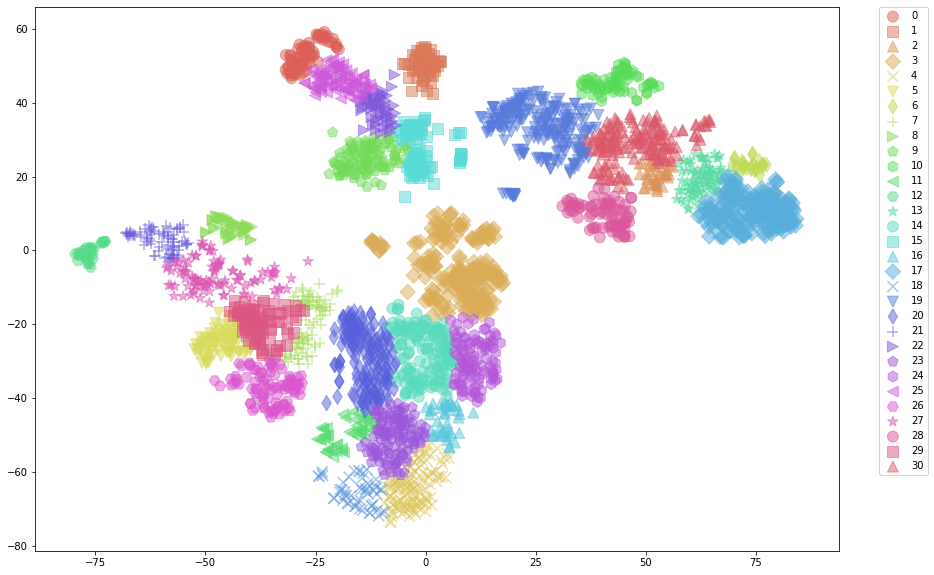

In [18]:
%%time
slcs.tsne_plot(figsize=(18, 10), alpha=0.5, s=120,
               n_txt_per_cluster=0, plot_different_markers=True,
               shuffle_label_colors=False, random_state=15)

### Identify cluster separating genes

In [19]:
cmp_labs = [1, 15, 22]

In [20]:
xgb_params = {"eta": 0.3,
              "max_depth": 1,
              "silent": 1,
              "nthread": 20,
              "alpha": 1,
              "lambda": 0,
              "seed": 123}

In [21]:
%%time
cmp_labs_sgs = slcs.feature_importance_across_labs(
    cmp_labs, nprocs=20, random_state=123, xgb_params=xgb_params,
    num_bootstrap_round=500, shuffle_features=True)

test rmse: mean 0.29898961799999996, std 0.04622533702208873
train rmse: mean 0.224621238, std 0.0222938908375076
CPU times: user 20min 26s, sys: 38.8 s, total: 21min 5s
Wall time: 3min 45s


In [22]:
sorted_cmp_labs_sgs = sorted(cmp_labs_sgs[0], key=lambda t: t[1], reverse=True)

In [23]:
[t[:4] for t in sorted_cmp_labs_sgs[:15]]

[('Lyz2', 2.107142857142857, 1.0120448082360538, 28),
 ('Pf4', 2.017857142857143, 1.026280931821501, 56),
 ('Ccl24', 2.0, 1.0954451150103321, 5),
 ('Tyrobp', 2.0, 0.7071067811865476, 4),
 ('Ccr1', 2.0, 0.0, 1),
 ('C1qb', 1.9127906976744187, 1.039039864448649, 344),
 ('F13a1', 1.8901734104046244, 0.9152317208646171, 173),
 ('Fcgr3', 1.8878504672897196, 0.9102439110699772, 107),
 ('Mrc1', 1.7959183673469388, 0.8801574960346051, 49),
 ('Ms4a7', 1.6666666666666667, 0.4714045207910317, 3),
 ('C1qa', 1.65, 0.852936105461599, 20),
 ('Cbr2', 1.3529411764705883, 0.8360394355030527, 34),
 ('Fcer1g', 1.3, 0.45825756949558405, 10),
 ('Clu', 1.2907608695652173, 0.4942291619843629, 368),
 ('Stab1', 1.2876712328767124, 0.6077006304881872, 73)]

The fields in each tuple are:

- Gene symbol.
- Mean of gene importance across 500 bootstrapping rounds.
- Standard deviation of gene importance across 500 bootstrapping rounds.
- Number of times of the gene is used in all bootstrapping rounds.

The importance of a gene in the trained classifier is the number of times it has been used as a inner node of the decision trees.

In [24]:
len(sorted_cmp_labs_sgs)

203

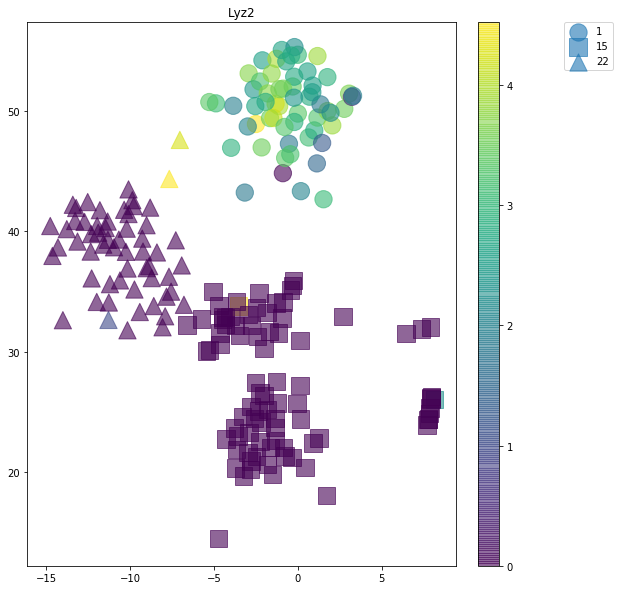

In [25]:
sgid = sorted_cmp_labs_sgs[0][0]
slcs.tsne_feature_gradient_plot(sgid, figsize=(11, 10), alpha=0.6, s=300,
                                selected_labels=cmp_labs,
                                transform=lambda x: np.log2(x+1),
                                title=sgid, n_txt_per_cluster=0,
                                plot_different_markers=True,
                                shuffle_label_colors=True, random_state=15)

## K-nearest neighbors

### Impute gene dropouts

In [26]:
%%time
kfi = sce.knn.FeatureImputation(sdm)
kfi_sdm = kfi.impute_features(
    k=[50], n_do=[15], min_present_val=[2],
    n_iter=[1], nprocs=1)[0]

CPU times: user 45.7 s, sys: 2.11 s, total: 47.8 s
Wall time: 47.9 s


In [27]:
%%time
kfi_tsne_x = kfi_sdm.tsne(perplexity=30, n_iter=3000, random_state=111)

CPU times: user 1min 19s, sys: 25.2 s, total: 1min 44s
Wall time: 1min 2s


CPU times: user 192 ms, sys: 193 ms, total: 385 ms
Wall time: 152 ms


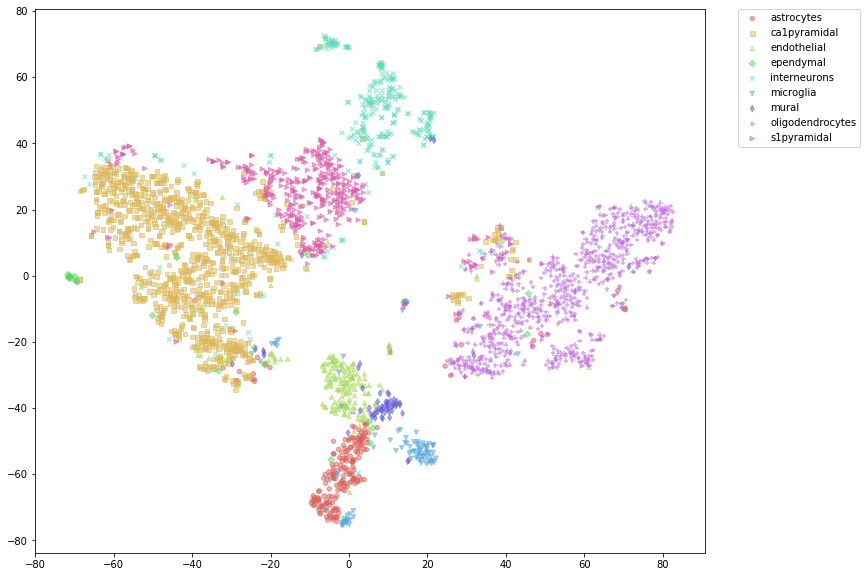

In [28]:
%%time
# t-SNE plot after imputation
kfi_sdm.tsne_plot(labels=labs, figsize=(15, 10), alpha=0.5, s=20,
                  n_txt_per_cluster=0, plot_different_markers=True,
                  shuffle_label_colors=False, random_state=15)

CPU times: user 85.4 ms, sys: 49.2 ms, total: 135 ms
Wall time: 65.3 ms


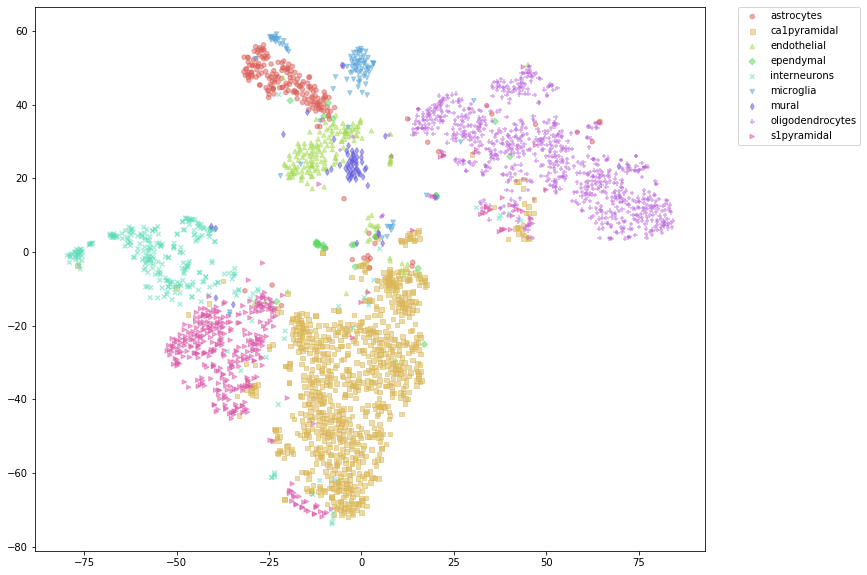

In [29]:
%%time
# t-SNE plot before imputation
sdm.tsne_plot(labels=labs, figsize=(15, 10), alpha=0.5, s=20,
              n_txt_per_cluster=0, plot_different_markers=True,
              shuffle_label_colors=False, random_state=15)

### Detect rare samples

In [30]:
rsd = sce.knn.RareSampleDetection(sdm)
non_rare_s_inds = rsd.detect_rare_samples(50, 0.3, 20)[0]

In [31]:
# number of rare samples
len(sdm.sids) - len(non_rare_s_inds)

133

In [32]:
# ratio of non-rare samples
len(non_rare_s_inds) / len(sdm.sids)

0.9557404326123128

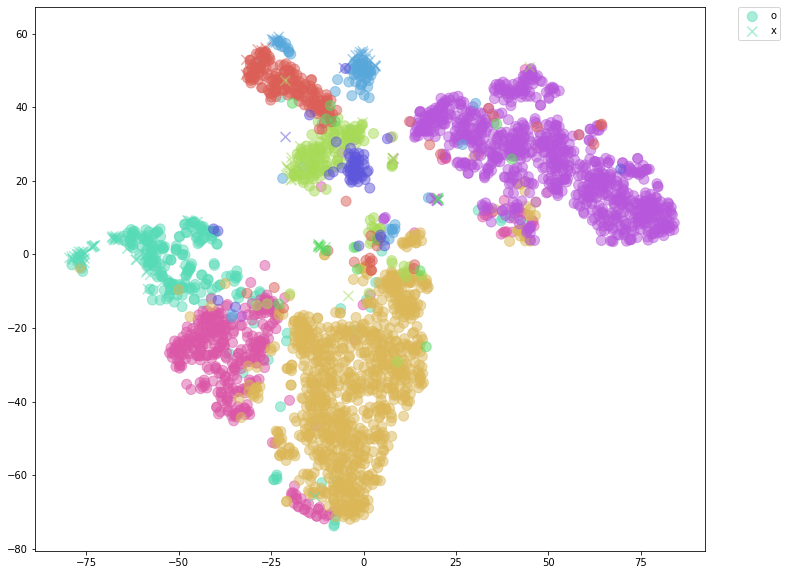

In [33]:
sdm.tsne_plot(labels=labs, s=100, figsize=(15, 10), alpha=0.5,
               n_txt_per_cluster=0, plot_different_markers=True,
               label_markers=['o' if i in non_rare_s_inds else 'x'
                              for i in range(len(sdm.sids))])

In [34]:
rsd_labs = np.array(['non-rare' if i in non_rare_s_inds else 'rare'
                     for i in range(len(sdm.sids))])[mirac_res._hac_tree.leaf_ids()].tolist()

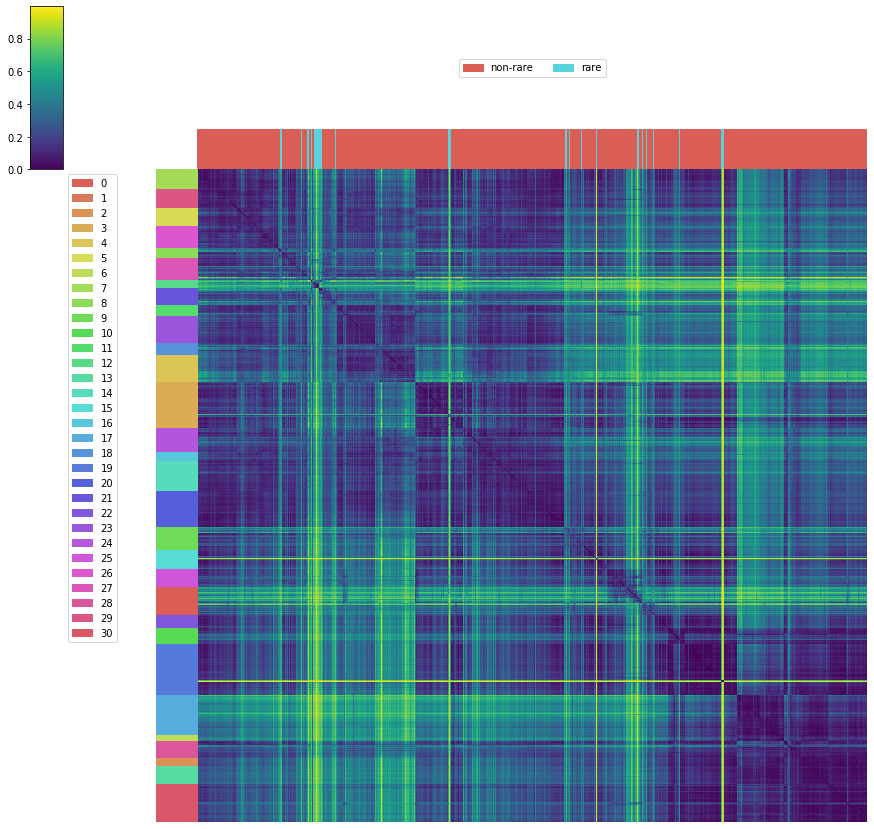

In [35]:
mirac_res.dmat_heatmap(col_labels=rsd_labs,
                       cmap='viridis', figsize=(15, 15))